<h1 style='color:green'> NASA - Airathon</h1> 

# Downloading OMI NO2 data from the following directory structure

    |--- no2
    |    |--- train
    |    |    |--- omi
    |    |    |    |___ <years>
    |    |    |         |___ <files>
    |    |    |___ tropomi
    |    |    |    |___ <years>
    |    |    |         |___ <files>
    |    |    |___ tropomi_hires
    |    |         |___ <years>
    |    |              |___ <files>
    |    |___ test
    |         |--- omi
    |         |    |___ <years>
    |         |         |___ <files>
    |         |___ tropomi
    |         |    |___ <years>
    |         |         |___ <files>
    |         |___ tropomi_hires
    |              |___ <years>
    |                   |___ <files> 

In [1]:
#path to store omi data 
storage_path_train = '../data/external/train'
storage_path_test = '../data/external/test'

# training data path (to download data from)
train_s3_path = 's3://drivendata-competition-airathon-public-us/no2/train/omi/'

#test data path 
test_s3_path = 's3://drivendata-competition-airathon-public-us/no2/test/omi/'

In [13]:
#downloading train data to '../data/external/'

!aws s3 cp $train_s3_path $storage_path_train --no-sign-request --recursive --quiet

In [ ]:
#downloading train data to '../data/external/'

!aws s3 cp $test_s3_path $storage_path_test --no-sign-request --recursive --quiet

# Resources 

* https://www.drivendata.co/blog/predict-pm25-benchmark/
* https://www.drivendata.co/blog/predict-no2-benchmark/

<h2 style='color:green'> Imports</h>

In [2]:
!pip install pqdm -q

In [3]:
import os
import random
import warnings
import re
from typing import Dict, List, Optional
from pathlib import Path

from h5py import File
from h5py import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import pyproj
import rasterio
from pqdm.processes import pqdm

from pyproj import CRS

wgs84_crs = CRS.from_epsg("4326")
#save requirements.txt
# !pip freeze > requirements.txt

#filter warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
# directories for data storage
DATA_PATH = Path.cwd().parent / "data"
RAW = DATA_PATH / "raw"
INTERIM = DATA_PATH / "interim"


# loading metadata

In [5]:
train_meta = pd.read_csv(
    RAW / "no2_satellite_metadata_0AF3h09.csv",
    parse_dates=["time_start", "time_end"],
    index_col=0
)

grid_meta = pd.read_csv(
    RAW / "grid_metadata.csv",
    index_col=0
                        )

train_labels = pd.read_csv(RAW/'train_labels.csv', parse_dates=["datetime"])
train_labels.rename(columns={"value": "no2"}, inplace=True)

train_labels.head(2)

,datetime,grid_id,no2
0,2019-01-01 08:00:00+00:00,3A3IE,8.695000
1,2019-01-01 08:00:00+00:00,3S31A,10.496667


In [6]:
#checking the grid data. Each grid cell has a 5-character alphanumeric grid_id that uniquely identifies a 
# 5 x 5 km grid cell and is associated with an observation in our train or test set.
grid_meta.head(2)

,location,tz,wkt
grid_id,,,
1X116,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 24.97766123020391,..."
1Z2W7,Delhi,Asia/Calcutta,"POLYGON ((77.30453178416276 28.54664454217707,..."


In [7]:
#checking the train metadata
train_meta.head(2)

,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size
granule_id,,,,,,,,,,
20190101T213357_tropomi_la_0.nc,2019-01-01 20:35:33+00:00,2019-01-01 21:33:57+00:00,tropomi,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1611277770,332149977
20190102T211456_tropomi_la_0.nc,2019-01-02 20:16:33+00:00,2019-01-02 21:14:56+00:00,tropomi,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1146925070,334150299


In [8]:
train_meta['split'].value_counts()

train    3156
test     1857
Name: split, dtype: int64

In [9]:
train_meta['product'].value_counts()

tropomi_hires    2750
tropomi          1193
omi              1070
Name: product, dtype: int64

In [10]:
train_meta['location'].value_counts()

la           1461
dl           1262
tpe          1220
dl-la-tpe    1070
Name: location, dtype: int64

**Taking data from only omi**

In [11]:
omi_meta = train_meta[train_meta['product']=='omi']
omi_meta.shape

(1070, 10)

In [12]:
# attaching train filepaths for train metadata
for dirs in os.listdir(storage_path_train):
    root_path = os.path.join(storage_path_train,dirs)
    for path in os.listdir(root_path):
        if (path in omi_meta.index.values):
            omi_meta.loc[path,'filepath'] = os.path.join(root_path,path)


/tmp/ipykernel_1096/1837270171.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omi_meta.loc[path,'filepath'] = os.path.join(root_path,path)


In [13]:
print(f'Number of tiles in train set are {omi_meta.filepath.notnull().sum()}')

Number of tiles in train set are 671


In [14]:
#setting the filepaths for test set 
for dirs in os.listdir(storage_path_test):
    root_path = os.path.join(storage_path_test,dirs)
    for path in os.listdir(root_path):
        if (path in omi_meta.index.values):
            omi_meta.loc[path,'filepath'] = os.path.join(root_path,path)

**Loading sample he5 file**

In [15]:
omi_meta.filepath.nunique()

1070

In [16]:
omi_meta.head()

,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,filepath
granule_id,,,,,,,,,,,
20190101T235959_omi_dl-la-tpe_0.he5,2019-01-01 00:00:00+00:00,2019-01-01 23:59:59+00:00,omi,dl-la-tpe,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2423440162,11127998,../data/external/train/2019/20190101T235959_om...
20190102T235959_omi_dl-la-tpe_0.he5,2019-01-02 00:00:00+00:00,2019-01-02 23:59:59+00:00,omi,dl-la-tpe,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3526775882,11169726,../data/external/train/2019/20190102T235959_om...
20190103T235959_omi_dl-la-tpe_0.he5,2019-01-03 00:00:00+00:00,2019-01-03 23:59:59+00:00,omi,dl-la-tpe,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,388814420,10937679,../data/external/train/2019/20190103T235959_om...
20190104T235959_omi_dl-la-tpe_0.he5,2019-01-04 00:00:00+00:00,2019-01-04 23:59:59+00:00,omi,dl-la-tpe,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1410261098,11141005,../data/external/train/2019/20190104T235959_om...
20190105T235959_omi_dl-la-tpe_0.he5,2019-01-05 00:00:00+00:00,2019-01-05 23:59:59+00:00,omi,dl-la-tpe,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1765932191,10819793,../data/external/train/2019/20190105T235959_om...


**checking a sample he5 file**

In [17]:
sample_no2 = File(omi_meta.filepath[10],
                  mode='r')

#print hierarchical structure of sample_no2 
def print_structure(name, obj):
    print(name)

sample_no2.visititems(print_structure)

HDFEOS
HDFEOS/ADDITIONAL
HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
HDFEOS/GRIDS
HDFEOS/GRIDS/ColumnAmountNO2
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2CloudScreened
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2Trop
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2TropCloudScreened
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/Weight
HDFEOS INFORMATION
HDFEOS INFORMATION/StructMetadata.0


**NO2 image desc** : 


    According to our raw values, a single swath of our Tropospheric Column NO2 data contains 720 x 1440 pixels that represent averaged values across approximately 14 orbits in a single day. Given that our NO2 data covers the entire globe and our data has a resolution of 0.25 x 0.25 degrees, this shape is to be expected:

        Given latitude bounds of [-90, 90], 180 / 0.25 = 720 pixels
        Given longitude bounds of [-180, 180], 360 / 0.25 = 1440 pixels



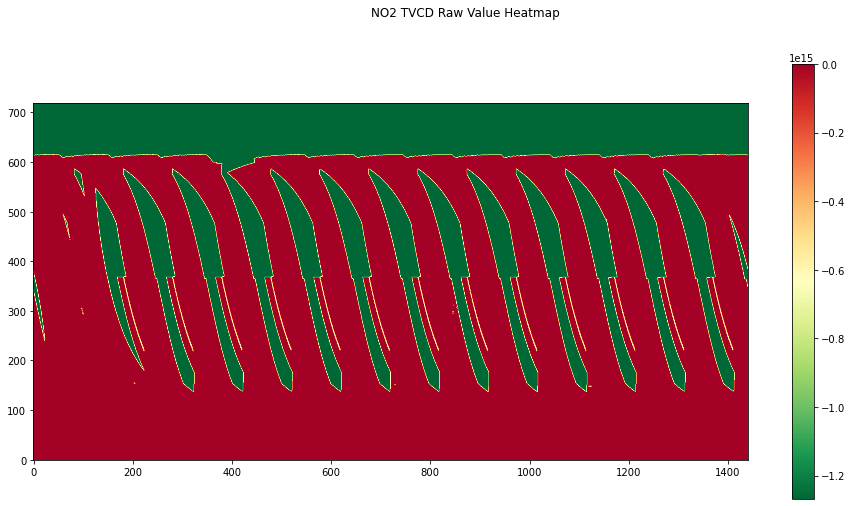

In [18]:
#selecting tropospheric n02 for viz

trop_no2 = sample_no2["HDFEOS"]["GRIDS"]["ColumnAmountNO2"]["Data Fields"]["ColumnAmountNO2Trop"]

f, ax = plt.subplots(1, 1, figsize=(16, 8))
img = plt.imshow(trop_no2[:] / 1e15 ,
                 origin="lower",
                 cmap="RdYlGn_r")

f.colorbar(img)
plt.suptitle("NO2 TVCD Raw Value Heatmap", fontsize=12)
plt.show()

In [19]:
# List available attributes
for k, v in trop_no2.attrs.items():
    print(f"{k}: {v}")

Description: b'Field=ColumnAmountNO2Trop,StdField=ColumnAmountNO2TropStd,SolarZenithAngle=[0:85],VcdQualityFlags=~19,XTrackQualityFlags=~[1:254],TerrainReflectivity=[0:1000]'
MissingValue: [-1.2676506e+30]
Offset: [0.]
ScaleFactor: [1.]
Title: b'NO2 tropospheric column density'
Units: b'molec/cm2'
_FillValue: [-1.2676506e+30]


# Processing data

    Aligning the training data and labels by georeferencing,along with dealing with no-data-values and callibration of offset

**Helper functions (from reference notebook with minor modifications)**

In [20]:
def calibrate_data(data: File, calibration_dict: Dict):
    """Given an OMI dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        data (File): dataset in the File format (e.g. column NO2).
        calibration_dict (Dict): dictionary containing, at a minimum,
            `scale_factor` (float), `offset` (float),
            `missing_data_value` (float).
    
    Returns:
        corrected_NO2 (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    # Convert missing data to nan
    data[data == calibration_dict["missing_data_value"]] = np.nan
    
    # Remove negative values
    data[data < 0] = np.nan
    
    # Calibrate using offset and scale factor
    data = (
        (data - calibration_dict["offset"]) *
        calibration_dict["scale_factor"]
    ) / (10 ** 15) # Divide by 10^15 for readability
    
    # Convert to masked array
    data = np.ma.masked_where(np.isnan(data), data)
    data.fill_value = np.nan

    return data

def create_calibration_dict(data: Dataset):
    """Define calibration dictionary given a Dataset object,
    which contains:
        - scale factor
        - offset
        - missing data value
    
    Args:
        data (Dataset): dataset in the Dataset format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    calibration_dict = {
        "scale_factor": data.attrs["ScaleFactor"][0],
        "offset": data.attrs["Offset"][0],
        "missing_data_value": data.attrs["_FillValue"][0]
    }
    return calibration_dict

def convert_array_to_df(
    corrected_arr: np.ma.MaskedArray,
    lat: np.ndarray,
    lon: np.ndarray,
    granule_id: str,
    total_bounds: Optional[np.ndarray] = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        total_bounds (np.ndarray, optional): If provided, will filter
            out points that fall outside of these bounds. Composed of
            xmin, ymin, xmax, ymax.
    """
    lons, lats = np.meshgrid(lon, lat)
    values = {
        "value": corrected_arr.data.ravel(),
        "lat": lats.ravel(),
        "lon": lons.ravel(),
        "granule_id": [granule_id] * lons.shape[0] * lons.shape[1]
    }
    df = pd.DataFrame(values).dropna()
    
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = wgs84_crs
    return gdf[["granule_id", "geometry", "value"]].reset_index(drop=True)

def define_coordinates(
    lat_bounds: List[float],
    lon_bounds: List[float],
    resolution: List[float]
):
    """Given latitude bounds, longitude bounds, and the data product 
    resolution, create a meshgrid of points between bounding coordinates.
    
    Args:
        lat_bounds (List): latitude bounds as a list.
        lon_bounds (List): longitude bounds as a list.
        resolution (List): data resolution as a list.
    
    Returns:
        lon (np.array): x (longitude) coordinates.
        lat (np.array): y (latitude) coordinates.
    """
    # Interpolate points between bounds
    # Add 0.125 buffer, source: OMI_L3_ColumnAmountO3.py (HDFEOS script)
    lon = np.arange(lon_bounds[0], lon_bounds[1], resolution[1]) + 0.125
    lat = np.arange(lat_bounds[0], lat_bounds[1], resolution[0]) + 0.125

    return lon, lat



In [29]:
def preprocess_omi_data(
    granule_path: str,
    grid_cell_gdf: gpd.GeoDataFrame,
    dataset_name: str,
    locations: List[str]
):
    """
    Given a granule s3 path and competition grid cells, 
    create a GDF of each intersecting point and the accompanying
    dataset value (e.g. Tropospheric NO2).
    
    Args:
        granule_path (str): a path to a granule on sys.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        dataset_name (str): specific dataset name (e.g. "ColumnAmountNO2Trop").
        locations (List[str]): location names to filter points
            using bounding coordinates. Options include Taipei, Delhi,
            and Los Angeles (SoCAB).
    
    Returns:
        GeoDataFrame that contains Points and associated values.
    """
    # Load NO2 data
    # s3_path = S3Path(granule_path)
    granule_name = granule_path.split('/')[-1]
    hdf = File(granule_path, mode="r")
    NO2 = hdf["HDFEOS"]["GRIDS"]["ColumnAmountNO2"]["Data Fields"][dataset_name]
    raw_NO2 = NO2[:]
    shape = raw_NO2.shape

    # Calibrate data
    calibration_dict = create_calibration_dict(NO2)
    corrected_NO2 = calibrate_data(raw_NO2, calibration_dict)

    # Determine location bounds
    bounds = [grid_cell_gdf[grid_cell_gdf.location == x].total_bounds for x in locations]
    
    # Save values that align with granules
    lon, lat = define_coordinates([-90, 90], [-180, 180], [0.25, 0.25])
    dfs = []
    for i, bound in enumerate(bounds):
        granule_gdf = convert_array_to_df(corrected_NO2, lat, lon, granule_name, bound)
        location_gdf = grid_cell_gdf[grid_cell_gdf.location == locations[i]]
        city_df = gpd.sjoin_nearest(location_gdf, granule_gdf, how="inner")
        dfs.append(city_df)
    df = pd.concat(dfs)

    # Clean up files
    # Path(s3_path.fspath).unlink()
    return df.drop(columns="index_right").reset_index()

    
def preprocess_trop_no2(
    granule_paths: List[str],
    grid_cell_gdf: gpd.GeoDataFrame,
    dataset_name: str,
    locations: List[str],
    n_jobs: int = 7
):
    """
    Given a set of granule s3 paths and competition grid cells, 
    parallelizes creation of GDFs containing NO2 values and points.
    
    Args:
        granule_paths (List[str]): list of paths on s3.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        dataset_name (str): specific dataset name (e.g. "ColumnAmountNO2Trop").
        locations (List[str]): location names to filter points
            using bounding coordinates. Options include Taipei, Delhi,
            and Los Angeles (SoCAB).
        n_jobs (int): The number of parallel processes. Defaults to 2.
    
    Returns:
        GeoDataFrame that contains Points and associated values for all granules.
    """
    args = ((gp, grid_cell_gdf, dataset_name, locations) for gp in granule_paths)
    results = pqdm(args, preprocess_omi_data, n_jobs=n_jobs, argument_type="args")
    return pd.concat(results)

Converting data into datasets

Getting Train and test filepaths, and location coordinates for the labelled data

In [22]:
# Identify training OMI granule filepaths
fp = list(omi_meta[omi_meta['split']=='train']['filepath'])

# Identify training grid cells
gc = grid_meta[grid_meta.index.isin(train_labels.grid_id)].copy()

len(gc)

66

Getting the location polygons for the selected grids

In [23]:
polys = gpd.GeoSeries.from_wkt(gc.wkt, crs=wgs84_crs)
polys.name = "geometry"
polys_gdf = gpd.GeoDataFrame(polys)
polys_gdf["location"] = gc.location

In [24]:
# Determine bounding boxes
locations = polys_gdf.location.unique()
bounds = [polys_gdf[polys_gdf.location == x].total_bounds for x in locations]

In [25]:
# getting datasets

**getting values of trop NO2**

In [26]:
train_gdf_trop_no2 = preprocess_trop_no2(fp, 
                                        polys_gdf,
                                        "ColumnAmountNO2Trop",
                                        locations)

#rename cols
train_gdf_trop_no2.rename(columns = {'value':'trop_no2'},inplace=True)


train_gdf_trop_no2.shape

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/671 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/671 [00:00<?, ?it/s]

(26403, 5)

**getting values of trop NO2 (cloud filtered)**

In [32]:
train_gdf_trop_cf_no2 = preprocess_trop_no2(fp, 
                                        polys_gdf,
                                        "ColumnAmountNO2TropCloudScreened",
                                        locations)

train_gdf_trop_cf_no2.rename(columns = {'value':'trop_no2_cs'},inplace=True)

train_gdf_trop_cf_no2.shape

(23435, 5)

**getting column no2 data**

In [52]:
train_gdf_col_no2 = preprocess_trop_no2(fp, 
                                        polys_gdf,
                                        "ColumnAmountNO2",
                                        locations)

train_gdf_col_no2.rename(columns = {'value':'col_no2'},inplace=True)
train_gdf_col_no2.shape

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/671 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/671 [00:00<?, ?it/s]

(26462, 5)

**getting column no2 data(cloud filtered**

In [64]:

train_gdf_col_cf_no2 = preprocess_trop_no2(fp, 
                                        polys_gdf,
                                        "ColumnAmountNO2CloudScreened",
                                        locations)

train_gdf_col_cf_no2.rename(columns = {'value':'col_no2_cs'},inplace=True)

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/671 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/671 [00:00<?, ?it/s]

**merging the above datasets**

In [154]:
#merging columns
on = ['grid_id','granule_id','geometry','location']
how = 'left'

In [155]:
#merging trop no2 with trop_no2 cloud screened
train_df = train_gdf_trop_no2.merge(train_gdf_trop_cf_no2,
                                    on = on ,
                                    how = how)

train_df.shape

(26403, 6)

In [156]:
#merging col no2
train_df = train_df.merge(train_gdf_col_no2,
                                    on = on ,
                                    how = how)


train_df.shape

(26403, 7)

In [157]:
#merging col no2 cloud filtered
train_df = train_df.merge(train_gdf_col_cf_no2,
                                    on = on ,
                                    how = how)


train_df.shape


(26403, 8)

# saving train_df

In [158]:
train_df.isnull().sum()

grid_id           0
geometry          0
location          0
granule_id        0
trop_no2          0
trop_no2_cs    2999
col_no2           0
col_no2_cs     2999
dtype: int64

In [159]:
#adding  a indicator for null values 

train_df['null_fields'] = train_df.isnull().sum(axis=1)

filling nulls with bfils

In [160]:
train_df=train_df.sort_values(by = 'location')
train_df['col_no2_cs'].bfill(inplace=True)
train_df['trop_no2_cs'].bfill(inplace=True)


In [162]:
train_df.to_csv(INTERIM / 'train_df.csv',
                index=False)

**getting test data**

In [129]:
# Identify test grid cells
submission_format = pd.read_csv(RAW / "submission_format.csv", 
                                parse_dates=["datetime"])

submission_format.head()

,datetime,grid_id,value
0,2018-09-08 08:00:00+00:00,3A3IE,0.0
1,2018-09-08 08:00:00+00:00,3S31A,0.0
2,2018-09-08 08:00:00+00:00,7II4T,0.0
3,2018-09-08 08:00:00+00:00,8BOQH,0.0
4,2018-09-08 08:00:00+00:00,A2FBI,0.0


In [133]:
test_gc = grid_meta[grid_meta.index.isin(submission_format.grid_id)]
test_gc.shape

(68, 3)

In [135]:
#test filepaths 
fp_test = list(omi_meta[omi_meta['split']=='test']['filepath'])

# Create grid cell GeoDataFrame
test_polys = gpd.GeoSeries.from_wkt(test_gc.wkt, crs=wgs84_crs)
test_polys.name = "geometry"
test_polys_gdf = gpd.GeoDataFrame(test_polys)
test_polys_gdf["location"] = test_gc.location

In [136]:
test_gdf_trop_no2 = preprocess_trop_no2(fp_test, 
                                        test_polys_gdf,
                                        "ColumnAmountNO2Trop",
                                        locations)

#rename cols
test_gdf_trop_no2.rename(columns = {'value':'trop_no2'},inplace=True)


test_gdf_trop_no2.shape

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/399 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/399 [00:00<?, ?it/s]

(15884, 5)

In [141]:
test_gdf_trop_cf_no2 = preprocess_trop_no2(fp_test, 
                                        test_polys_gdf,
                                        "ColumnAmountNO2TropCloudScreened",
                                        locations)

#rename cols
test_gdf_trop_cf_no2.rename(columns = {'value':'trop_no2_cs'},inplace=True)


test_gdf_trop_cf_no2.shape

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/399 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/399 [00:00<?, ?it/s]

(14919, 5)

In [144]:
test_gdf_col_no2 = preprocess_trop_no2(fp_test, 
                                        test_polys_gdf,
                                        "ColumnAmountNO2",
                                        locations)

#rename cols
test_gdf_col_no2.rename(columns = {'value':'col_no2'},inplace=True)


test_gdf_col_no2.shape

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/399 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/399 [00:00<?, ?it/s]

(15983, 5)

In [145]:
test_gdf_col_cf_no2 = preprocess_trop_no2(fp_test, 
                                        test_polys_gdf,
                                        "ColumnAmountNO2CloudScreened",
                                        locations)

#rename cols
test_gdf_col_cf_no2.rename(columns = {'value':'col_no2_cs'},inplace=True)


test_gdf_col_cf_no2.shape

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/399 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/399 [00:00<?, ?it/s]

(14952, 5)

**Merging test df**

In [147]:
#merging columns
on = ['grid_id','granule_id','geometry','location']
how = 'left'

In [148]:
#merging trop no2 with trop_no2 cloud screened
test_df = test_gdf_trop_no2.merge(test_gdf_trop_cf_no2,
                                    on = on ,
                                    how = how)
#merging col no2
test_df = test_df.merge(test_gdf_col_no2,
                                    on = on ,
                                    how = how)

#merging col no2 cloud filtered
test_df = test_df.merge(test_gdf_col_cf_no2,
                                    on = on ,
                                    how = how)


test_df.shape

(15884, 8)

In [166]:
train_df.columns

Index(['grid_id', 'geometry', 'location', 'granule_id', 'trop_no2',
       'trop_no2_cs', 'col_no2', 'col_no2_cs', 'null_fields'],
      dtype='object')

In [165]:
test_df.columns

Index(['grid_id', 'geometry', 'location', 'granule_id', 'trop_no2',
       'trop_no2_cs', 'col_no2', 'col_no2_cs', 'null_fields'],
      dtype='object')

In [149]:
test_df['null_fields'] = test_df.isnull().sum(axis=1)
test_df.isnull().sum()

grid_id          0
geometry         0
location         0
granule_id       0
trop_no2         0
trop_no2_cs    965
col_no2          0
col_no2_cs     932
null_fields      0
dtype: int64

In [150]:
test_df=test_df.sort_values(by = 'location')
test_df['col_no2_cs'].bfill(inplace=True)
test_df['trop_no2_cs'].bfill(inplace=True)


In [151]:
test_df.shape

(15884, 9)

In [170]:
test_df.null_fields.value_counts()

0    14919
2      932
1       33
Name: null_fields, dtype: int64

In [153]:
test_df.to_csv(INTERIM / 'test_df.csv',
                index=False)